In [1]:
import random

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, Ridge
import simplstyles

from simulation import generate_dataset

In [2]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord-light-talk')
random.seed(42)

/home/leo/PycharmProjects/compare_variance_residual/venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [16]:
d_list = [100, 100, 100]
# scalars = [1 / 3, 1 / 2, 1 / 6]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_target = 0.1
noise_feature = 0.01

In [4]:
alphas = np.logspace(-4, 4, 10)
cv = 2
score_func = himalaya.scoring.r2_score
use_ols = False

In [5]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target, noise_feature)

KeyboardInterrupt: 

first of all lets verify that Ridge regression with $\alpha = 0$ indeed is equivalent to linear regression

In [8]:
# ridge = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
# ridge.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
# ridge_coef = ridge.coef_  # (n_features, n_targets)

In [9]:
# linear = LinearRegression()
# linear.fit(backend.to_numpy(Xs[0][:n_samples_train]), backend.to_numpy(Y[:n_samples_train]))
# linear_coef = linear.coef_  # (n_targets, n_features)
# # swap rows and columns
# linear_coef = linear_coef.T

In [10]:
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).mean())
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).max())
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).min())
# sns.displot(backend.to_numpy(linear_coef) - backend.to_numpy(ridge_coef))


compute on full feature sets for comparison

0.7310072
0.41841826


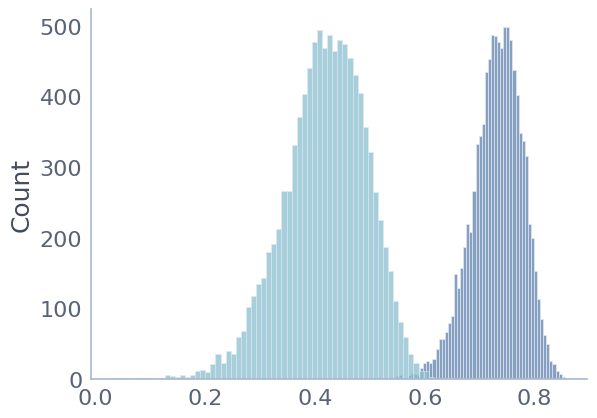

In [11]:
full_scores = []
for i in range(len(Xs)):
    full_model = RidgeCV(alphas=alphas, cv=cv,
                         solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    full_model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    full_score = full_model.score(Xs[i][n_samples_train:], Y[n_samples_train:])
    full_score = backend.to_numpy(full_score)
    print(full_score.mean())
    sns.histplot(full_score)
    full_scores.append(full_score)

# Feature to feature regression

In [12]:
if use_ols:
    feature_model = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
else:
    feature_model = RidgeCV(alphas=alphas, cv=cv, solver_params=(
        dict(warn=False, score_func=score_func, n_targets_batch=1000)))

In [13]:
feature_scores = []
Xs_predict = []
for i in range(len(Xs)):
    i_from = (i + 1) % len(Xs)
    i_to = i
    feature_model.fit(Xs[i_from][:n_samples_train], Xs[i_to][:n_samples_train])

    X_predict = feature_model.predict(Xs[i_from])
    X_predict = backend.asarray(X_predict)
    Xs_predict.append(X_predict)
    feature_score = feature_model.score(Xs[i_from][n_samples_train:], Xs[i_to][n_samples_train:])
    feature_score = backend.to_numpy(feature_score)
    feature_scores.append(feature_score)

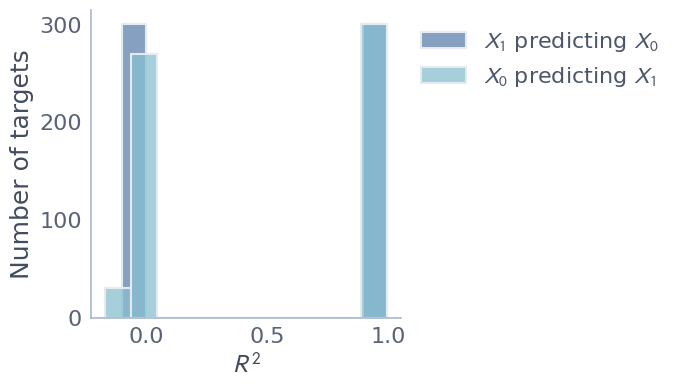

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i, score in enumerate(feature_scores):
    sns.histplot(score, label=rf'$X_{(i + 1) % 2}$ predicting $X_{i}$')

plt.xlabel(r"$R^2$")
plt.ylabel("Number of targets")
sns.despine()
# plot legend to the top right
plt.legend(bbox_to_anchor=(1, 1))

Compute residuals

In [15]:
Xs_residual = []
for i in range(len(Xs)):
    X_residual = Xs[i] - Xs_predict[i]
    X_residual = backend.asarray(X_residual)
    Xs_residual.append(X_residual)

# Train residual model

0.43574652
0.13490131


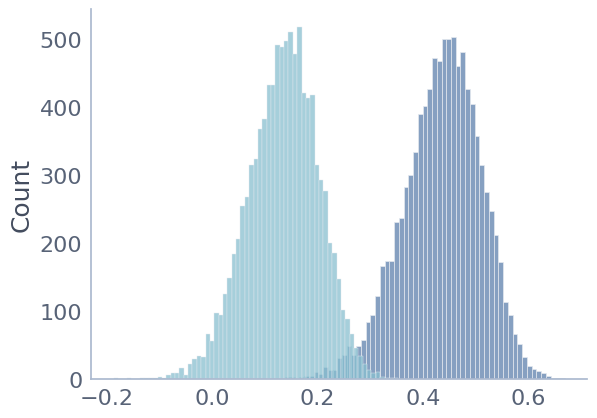

In [16]:
residual_scores = []
for i in range(len(Xs)):
    residual_model = RidgeCV(alphas=alphas, cv=cv,
                             solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    residual_model.fit(Xs_residual[i][:n_samples_train], Y[:n_samples_train])
    residual_score = residual_model.score(Xs_residual[i][n_samples_train:], Y[n_samples_train:])
    residual_score = backend.to_numpy(residual_score)
    print(residual_score.mean())
    sns.histplot(residual_score)
    residual_scores.append(residual_score)

# Plot Scores

In [17]:
import pandas as pd
import os

path = os.path.join('results', f'residual_method_{scalars}.csv')
if not os.path.exists(path):
    scores = pd.DataFrame()
    scores[r"$X_1\hat{\beta}_{ridge}=Y$"] = full_scores[0]
    scores[r"$X_2\hat{\beta}_{ridge}=Y$"] = full_scores[1]
    # scores[r"$X_1\beta \approx X_2$"] = np.concatenate(
    #     [feature_scores[0], np.full(len(full_scores[0]) - len(feature_scores[0]), np.nan)])
    # scores[r"$X_2\beta \approx X_1$"] = np.concatenate(
    #     [feature_scores[1], np.full(len(full_scores[0]) - len(feature_scores[1]), np.nan)])
    scores[r"$X_1'\hat{\beta}_{ridge}=Y$"] = residual_scores[0]
    scores[r"$X_2'\hat{\beta}_{ridge}=Y$"] = residual_scores[1]
    scores.to_csv(path)
else:
    scores = pd.read_csv(path, index_col=0)

scores.head()

,$X_1\beta \approx Y$,$X_2\beta \approx Y$,$X_1\beta \approx X_2$,$X_2\beta \approx X_1$,$X_1'\beta \approx Y$,$X_2'\beta \approx Y$,$X_1'$,$X_2'$
0,0.564049,0.566548,0.988389,0.990189,0.305743,0.371992,0.305743,0.371992
1,0.553289,0.591633,0.983175,0.987134,0.213122,0.261317,0.213122,0.261317
2,0.617415,0.676099,0.982617,0.985536,0.387216,0.348287,0.387216,0.348287
3,0.579412,0.633658,0.983303,0.980200,0.200950,0.334597,0.200950,0.334597
4,0.527503,0.531322,0.992214,0.991104,0.160141,0.312898,0.160141,0.312898


Text(0.5, 0, 'Feature Space')

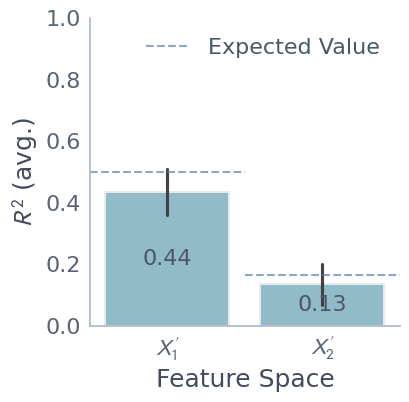

In [26]:
simple_scores = pd.DataFrame()
simple_scores[r"$X_1'$"] = residual_scores[0]
simple_scores[r"$X_2'$"] = residual_scores[1]

fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(
    data=simple_scores,
    palette=["C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)

# Add lines indicating the maximum possible height for each bar
theoretical_scores = [
    scalars[1],
    scalars[2],
]

for idx, column in enumerate(simple_scores.columns):  # iterate over rows in the DataFrame
    # Ensure index compatibility
    if column not in simple_scores:
        print(f"Column '{column}' is not present in DataFrame. Available columns are: {list(simple_scores.columns)}")
        continue

    xmin = idx / len(simple_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(simple_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, xmin=xmin, xmax=xmax,
                label='Expected Value' if idx == 0 else "")

    # Use the mean of the column for positioning text
    mean_column_value = simple_scores[column].mean()
    plt.text(idx, mean_column_value / 2, f"{mean_column_value:.2f}", ha='center', va='center')

# make xtickmarks diagonal
plt.xticks(range(len(simple_scores.columns)), simple_scores.columns)

plt.ylim(0, 1)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg.)")
plt.xlabel("Feature Space")

In [19]:
# drop columns 2,3 and 6, 7
scores = scores.drop(columns=scores.columns[[2, 3, 6, 7]])

# rename dataframe columns
scores.columns = [
    r"A,B",
    r"A,C",
    r"B",
    r"C",
]

Text(0.5, 0, 'Feature Space(s)')

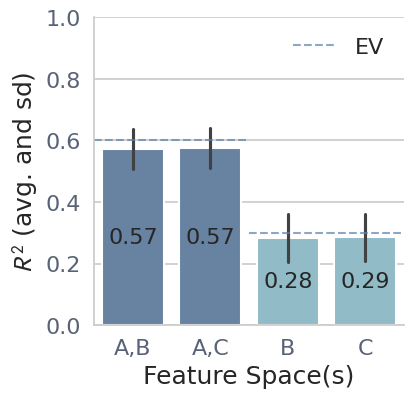

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=scores,
    ax=ax,
    palette=["C0", "C0", "C1", "C1"],
    errorbar="sd"
)

sns.despine()

# Add lines indicating the maximum possible height for each bar
theoretical_scores = [
    (scalars[0] + scalars[1]) * (1 - noise_target),
    (scalars[0] + scalars[2]) * (1 - noise_target),
    scalars[1] * (1 - noise_target),
    scalars[2] * (1 - noise_target),
]

for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    # Ensure index compatibility
    if column not in scores:
        print(f"Column '{column}' is not present in DataFrame. Available columns are: {list(scores.columns)}")
        continue

    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, xmin=xmin, xmax=xmax,
                label='EV' if idx == 0 else "")

    # Use the mean of the column for positioning text
    mean_column_value = scores[column].mean()
    plt.text(idx, mean_column_value / 2, f"{mean_column_value:.2f}", ha='center', va='center')

# make xtickmarks diagonal
plt.xticks(range(len(scores.columns)), scores.columns, va='top')

plt.ylim(0, 1)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg. and sd)")
plt.xlabel("Feature Space(s)")